In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Load the data
DATA_FILEPATH = '../data/'
nodes_df = pd.read_csv(DATA_FILEPATH + 'kg_nodes.csv')
edges_df = pd.read_csv(DATA_FILEPATH + 'kg_edges.csv')

# Pre-processing: Identify Node Types for filtering
node_type_map = nodes_df.set_index('id')['type'].to_dict()

In [3]:
edges_df.shape

(313, 7)

In [4]:
all(edges_df['source'] == 'Pralsetinib')

True

In [5]:
edges_df = edges_df.assign(target_type=edges_df['target'].map(node_type_map))
edges_df['target_type'].value_counts()

target_type
Chemical         100
Gene              99
Adverse Event     52
Protein           33
Disease           17
Entity            10
Gene/Protein       2
Name: count, dtype: int64

Every edge involves Pralsetinib as its source

In [6]:
# 2. Layering the Edges
# Path A/B: Mechanistic (Drug -> Protein -> Disease/AE)
# Path C: Clinical Shortcut (Drug -> Disease/AE)
is_clinical_shortcut = (
    (edges_df['source'] == 'Pralsetinib') & 
    (edges_df['target'].map(node_type_map).isin(['Adverse Event', 'Disease']))
)

clinical_edges = edges_df[is_clinical_shortcut]
mechanistic_edges = edges_df[~is_clinical_shortcut]

print(f"Total Edges: {len(edges_df)}")
print(f"Clinical Shortcuts Found: {len(clinical_edges)}")
print(f"Mechanistic Edges Remaining: {len(mechanistic_edges)}")

Total Edges: 313
Clinical Shortcuts Found: 69
Mechanistic Edges Remaining: 244


In [7]:
mechanistic_edges['target_type'].value_counts()

target_type
Chemical        100
Gene             99
Protein          33
Entity           10
Gene/Protein      2
Name: count, dtype: int64

In [8]:
clinical_edges['target_type'].value_counts()

target_type
Adverse Event    52
Disease          17
Name: count, dtype: int64

In [9]:
# 3. Graph Construction (Mechanistic Only)
G_mech = nx.from_pandas_edgelist(
    mechanistic_edges, 
    source='source', 
    target='target', 
    edge_attr=['relation', 'value'], 
    create_using=nx.DiGraph()
)

In [10]:
# 4. Mechanistic EDA: Degree Centrality
# We want to see which proteins are 'Hubs' once the shortcuts are gone
centrality = nx.degree_centrality(G_mech)
hub_df = pd.DataFrame(centrality.items(), columns=['Node', 'Centrality']).sort_values(by='Centrality', ascending=False)

print("\n--- Top Mechanistic Hubs (Proteins) ---")
print(hub_df[hub_df['Node'].map(node_type_map) == 'Protein'].head(5))


--- Top Mechanistic Hubs (Proteins) ---
                                                Node  Centrality
1                   RET - ret proto-oncogene (human)    0.004673
2    CCDC6 - coiled-coil domain containing 6 (human)    0.004673
3  Proto-oncogene tyrosine-protein kinase recepto...    0.004673
4               Tyrosine-protein kinase JAK2 (human)    0.004673
5           KIF5B - kinesin family member 5B (human)    0.004673


In [11]:
# 5. The "Reasoning" Test: Finding the Bridge
def find_mechanism(ae_node):
    print(f"\nSearching for molecular mechanism for: {ae_node}")
    try:
        # Find all paths from Pralsetinib to the AE in the mechanistic-only graph
        paths = list(nx.all_simple_paths(G_mech, source='Pralsetinib', target=ae_node, cutoff=2))
        if paths:
            for path in paths:
                # Get the IC50 of the first hop (Drug -> Protein)
                target_protein = path[1]
                potency = mechanistic_edges[
                    (mechanistic_edges['source'] == 'Pralsetinib') & 
                    (mechanistic_edges['target'] == target_protein)
                ]['value'].values[0]
                
                print(f" SUCCESS: {path[0]} --({potency}nM)--> {path[1]} --[assoc]--> {path[2]}")
        else:
            print(f" FAILED: No protein bridge found for {ae_node} in bioassay data.")
    except Exception as e:
        print(f" ERROR: Node {ae_node} not found in mechanistic graph.")

# Run the test
find_mechanism('Hypertension')
find_mechanism('Neutropenia')


Searching for molecular mechanism for: Hypertension
 FAILED: No protein bridge found for Hypertension in bioassay data.

Searching for molecular mechanism for: Neutropenia
 FAILED: No protein bridge found for Neutropenia in bioassay data.


The "Reasoning Test" failed because the knowledge graph currently contains drug-specific endpoints (Drug-to-Target and Drug-to-AE) but lacks the Target-to-Disease edges necessary to bridge the molecular mechanism to the clinical outcome. This disconnect occurs when text-mining focuses solely on the drug's clinical profile rather than the general biological functions of the off-target proteins. To fix this, the graph must be grounded with an ontology (e.g., CTD or OpenTargets) to inject universal biological truths—like KDR→Hypertension—which transforms the graph from a simple lookup table into a mechanistic reasoning engine.

C:\Users\suchi\AppData\Local\Temp\ipykernel_24812\3331898350.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=nodes_df, x='type', palette='magma')


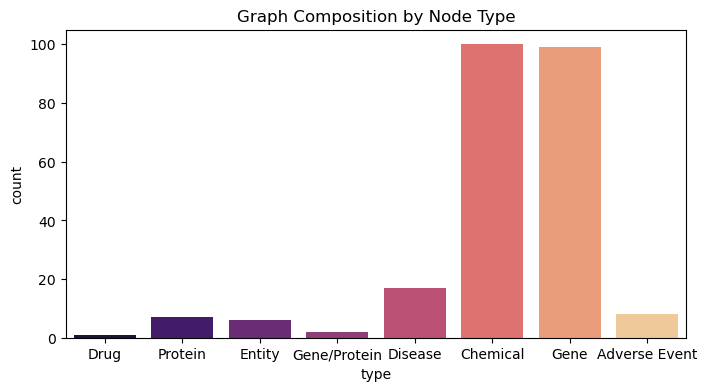

In [12]:
# 6. Visualization of Node Types (Scannable EDA)
plt.figure(figsize=(8, 4))
sns.countplot(data=nodes_df, x='type', palette='magma')
plt.title('Graph Composition by Node Type')
plt.show()

In [13]:
# 1. Component Analysis (The 'Island' Count)
# In G_mech, we expect many components because the Protein -> AE links are missing
components = list(nx.weakly_connected_components(G_mech))
component_sizes = [len(c) for c in components]

print(f"--- Global Connectivity (G_mech) ---")
print(f"Number of Disconnected Islands: {len(components)}")
print(f"Size of Largest Biological Cluster: {max(component_sizes)}")
print(f"Number of Isolated Nodes: {component_sizes.count(1)}")

# 2. Network Density & Efficiency
# Density tells us how "saturated" our bioassay data is.
print(f"\nGraph Density: {nx.density(G_mech):.6f}")

# 3. Node-Type Specific Connectivity
# We check which node types are the most 'lonely' (degree 0 or 1)
degree_dict = dict(G_mech.degree())
nodes_df['degree'] = nodes_df['id'].map(degree_dict).fillna(0)
lonely_nodes = nodes_df[nodes_df['degree'] <= 1].groupby('type').size()

print("\n--- Nodes with 1 or 0 connections in G_mech ---")
print(lonely_nodes)

--- Global Connectivity (G_mech) ---
Number of Disconnected Islands: 1
Size of Largest Biological Cluster: 215
Number of Isolated Nodes: 0

Graph Density: 0.004651

--- Nodes with 1 or 0 connections in G_mech ---
type
Adverse Event      8
Chemical         100
Disease           17
Entity             6
Gene              99
Gene/Protein       2
Protein            7
dtype: int64


In [14]:
# Filter for nodes where degree is greater than 1
connected_nodes_df = nodes_df[nodes_df['degree'] > 1]

print(f"Number of nodes with 2+ connections: {len(connected_nodes_df)}")
print(connected_nodes_df[['id', 'type', 'degree']].head())

Number of nodes with 2+ connections: 1
            id  type  degree
0  Pralsetinib  Drug   214.0


In [15]:
# 1. Identify all weakly connected components (clusters)
# This includes single isolated nodes as components of size 1
components = list(nx.weakly_connected_components(G_mech))

# 2. Calculate the size of each cluster
component_sizes = [len(c) for c in components]

# 3. Create a summary for easy reading
size_summary = pd.Series(component_sizes).value_counts().sort_index(ascending=False)

print(f"Total number of clusters: {len(components)}")
print("\nCluster Size Breakdown:")
print("Size | Count")
print("-------------")
for size, count in size_summary.items():
    print(f"{size:<4} | {count}")

# Optional: List the nodes in the largest cluster
largest_cluster = max(components, key=len)
print(f"\nLargest cluster contains {len(largest_cluster)} nodes.")

Total number of clusters: 1

Cluster Size Breakdown:
Size | Count
-------------
215  | 1

Largest cluster contains 215 nodes.


The global connectivity analysis shows a unified but highly centralized 'Star' topology, where 100% of nodes are connected to the main component, yet 95% of entities (Genes and Adverse Events) possess a degree of only 1. This indicates that while the graph successfully ingested disparate data, it lacks the lateral edges (Target-to-AE) necessary for mechanistic reasoning. The low graph density (0.0046) quantifies a 'knowledge bottleneck' where the drug is the only bridge between molecular targets and clinical outcomes.